In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
import glob
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers


# Data Processing

In [2]:
#Define the shape of the images and the batch size
image_size = (500, 500)
batch_size = 32

In [3]:
#Set the paths for the train and validation directories
train_dir = pathlib.Path('Data/train')
val_dir = pathlib.Path('Data/valid')

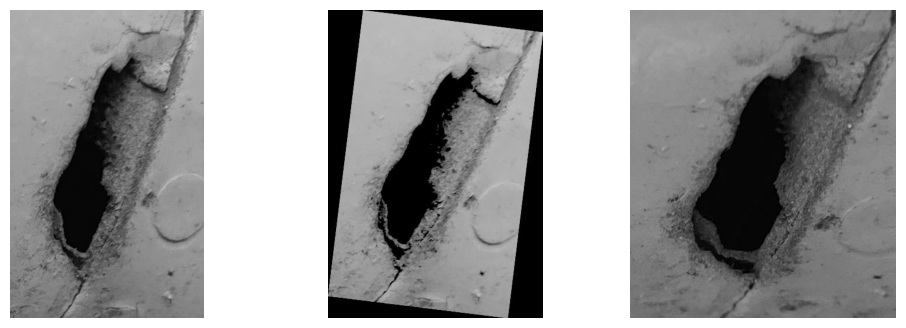

In [4]:
#Printing a few examples from the training set
cracks = list(train_dir.glob('crack/*'))

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i in range(3):
    image = Image.open(str(cracks[i]))
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

In [5]:
#Create train and validation datasets
train_ds = image_dataset_from_directory(
    train_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
)

val_ds = image_dataset_from_directory(
    val_dir, 
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',
    seed = 42,
)

Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


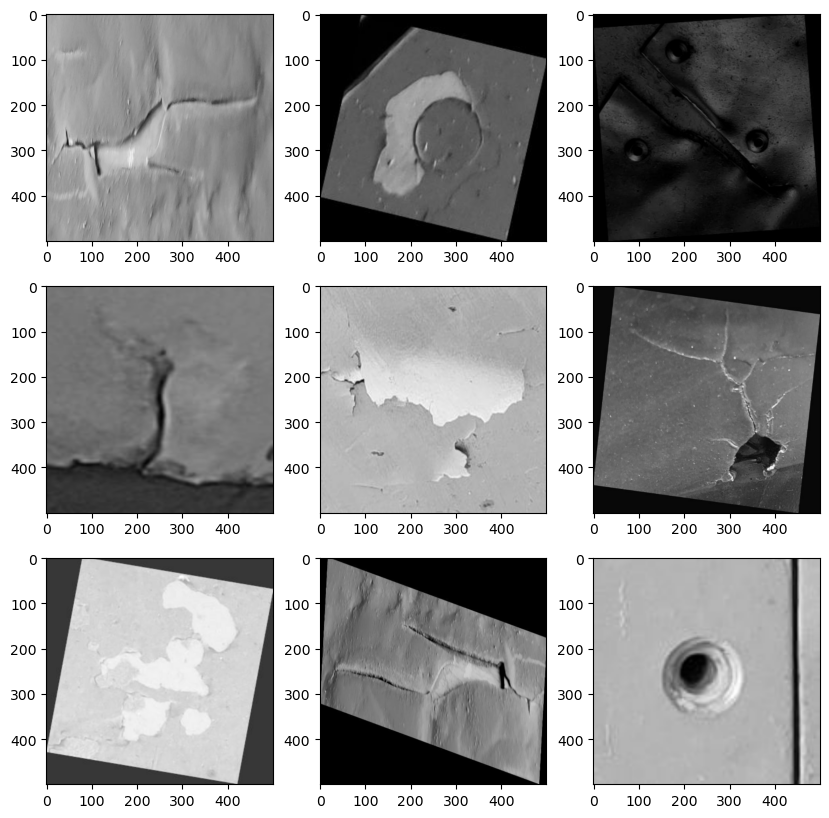

In [6]:
#Visualizing images from dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
       # plt.axis("off")

In [7]:
#Performance tuning the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [8]:
#Define rescale layer to be used as part of the model

rescale = tf.keras.Sequential([
    keras.layers.Rescaling(1./255),
])

In [9]:
#Data agmentation layers for the training set only

data_augmentation = keras.models.Sequential([
    keras.layers.RandomZoom(0.2), 
    keras.layers.RandomRotation(0.2)
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [10]:
#Building the first model

model = keras.models.Sequential([
    rescale,
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 2, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, 'softmax')
])

model.build((None, 500, 500, 3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 250, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 125, 64)     

In [11]:
#Complile the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy']
)

In [12]:
#Define checkpoint and early stopping callbacks

checkpoint_cb = keras.callbacks.ModelCheckpoint("current_model.h5")

early_stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

callbacks = [checkpoint_cb, early_stop_cb]


In [32]:
#Fitting and training the model

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100,
    callbacks=callbacks
)

Epoch 1/100
61/61 [==============================] - 34s 523ms/step - loss: 1.0841 - accuracy: 0.3708 - val_loss: 0.9992 - val_accuracy: 0.4872
Epoch 2/100
61/61 [==============================] - 31s 500ms/step - loss: 0.9501 - accuracy: 0.5623 - val_loss: 0.7947 - val_accuracy: 0.6427
Epoch 3/100
61/61 [==============================] - 31s 514ms/step - loss: 0.8569 - accuracy: 0.5865 - val_loss: 0.7448 - val_accuracy: 0.6682
Epoch 4/100
61/61 [==============================] - 31s 510ms/step - loss: 0.7564 - accuracy: 0.6298 - val_loss: 0.7019 - val_accuracy: 0.6659
Epoch 5/100
61/61 [==============================] - 31s 506ms/step - loss: 0.6708 - accuracy: 0.6807 - val_loss: 0.6545 - val_accuracy: 0.6752
Epoch 6/100
61/61 [==============================] - 31s 505ms/step - loss: 0.6573 - accuracy: 0.6982 - val_loss: 0.6535 - val_accuracy: 0.6868
Epoch 7/100
61/61 [==============================] - 31s 509ms/step - loss: 0.6186 - accuracy: 0.7214 - val_loss: 0.6477 - val_accuracy:

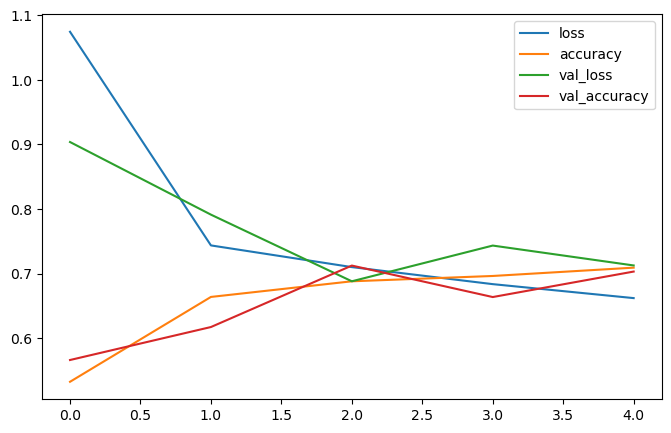

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()